In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, vectorize

np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# 4.4 Two Gaussians

$$
P(x)=\frac{e^{-0.5⋅(x-3)^2}+e^{-0.5⋅(x+3)^2}}{2\sqrt{2π}} \tag{4.14}
$$

$$
S(x)=-ln(e^{-0.5⋅(x-3)^2}+e^{-0.5⋅(x+3)^2}) \tag{4.15}
$$

$$ S(x)=-ln(P(x)) $$

In [2]:
sqrt = np.sqrt
π = np.pi
exp = np.exp
ln = np.log

In [3]:
@njit
def P(x, shift=3):
    p1 = exp(-0.5 * (x - shift) ** 2)
    p2 = exp(-0.5 * (x + shift) ** 2)
    return (p1 + p2) / (2 * sqrt(2 * π))


@njit
def S(x, shift=3):
    return -ln(P(x, shift))

In [4]:
@njit
def mcmc(S, K=10_000, step=0.5, shift=3):
    dx_rand = np.random.rand(K)
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = S(x[k - 1], shift)
        dx = (dx_rand[k] - 0.5) * step * 2.0  # ±step
        x[k] = x[k - 1] + dx  # new x
        fin = S(x[k], shift)
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[:].sum() / K


K = 100_000
shift = 3
x, acc_ratio = mcmc(S, K=K, shift=shift)
acc_ratio

0.902

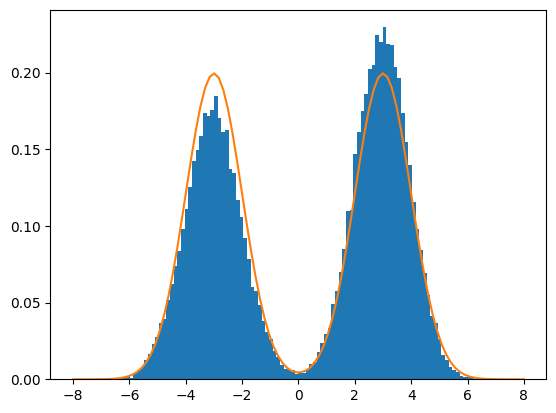

In [5]:
fig, ax = plt.subplots(1, 1)

x_exact = np.linspace(-8, 8, 100)
ax.hist(x, 100, density=True)

ax.plot(x_exact, P(x_exact));

$$
P(x) = \begin{cases}
\begin{matrix}
    [x≥0]       & (\frac{exp[-x^2/2]}{\sqrt{2π}}) \\
    [-1≤x<0]    & ({2/π\sqrt{1-x^2}}) \\
    [x < -1]    & (0)
\end{matrix}
\end{cases}
\tag{4.16}
$$

In [6]:
@vectorize
def P(x):
    if x >= 0:
        p = exp(-0.5 * x**2) / sqrt(2 * π)
    if -1 <= x < 0:
        p = 2 / π * sqrt(1 - x**2)
    if x < -1:
        p = 0.0
    return p

@njit
def S(x):
    return -ln(P(x))

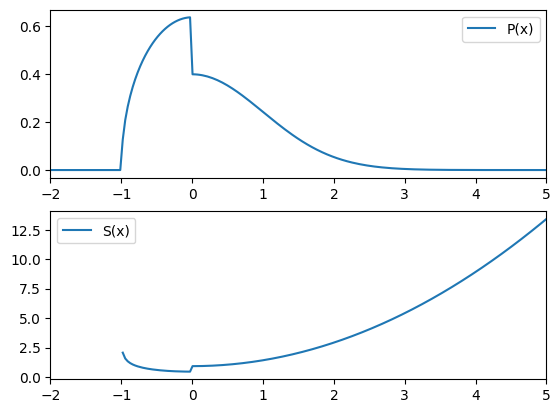

In [10]:
fig, [ax0, ax1] = plt.subplots(2, 1)
p = dict(xlim=[-2, 5])
ax0.set(**p)
ax1.set(**p)

x = np.linspace(-2, 5, 200)

ax0.plot(x, P(x), label="P(x)")
ax1.plot(x, S(x), label="S(x)")

ax0.legend(), ax1.legend();

In [16]:
@njit
def mcmc(S, K=10_000, step=0.5):
    dx_rand = np.random.rand(K)
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = S(x[k - 1])
        dx = (dx_rand[k] - 0.5) * step * 2.0  # ±step
        x[k] = x[k - 1] + dx  # new x
        fin = S(x[k])
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[:].sum() / K


K = 10_000
shift = 3
x, acc_ratio = mcmc(S, K=K)
acc_ratio

0.8374

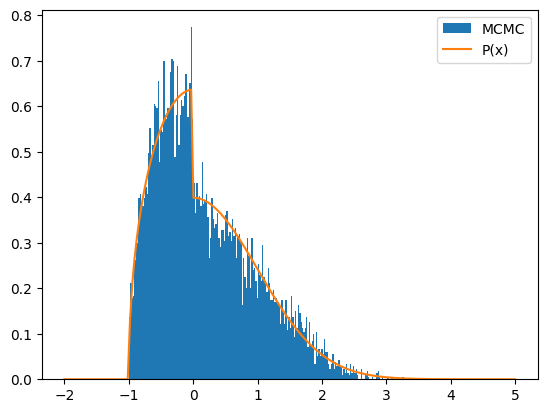

In [17]:
fig, ax = plt.subplots(1,1)

x_exact = np.linspace(-2, 5, 200)

ax.hist(x, 200, density=True, label="MCMC")
ax.plot(x_exact, P(x_exact), label="P(x)")

ax.legend();